In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json
import os
import time
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

import h5py

from alvra_tools import *
from alvra_tools.channels import *
#from alvra_tools.channels_raw import *

[INFO][corrections] Numba not available, reverting to Numpy


In [2]:
# Take the correct pedestal file (usually located in /sf/alvra/data/*pgroup*/res/JF_pedestals)
# Take the correct gains.h5 file (usually located in /sf/alvra/config/jungfrau/gainMaps/JF02T09V01/)

#pede_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190723_1255.JF02T09V02.res.h5"
pede_file = "/sf/alvra/data/p17983/res/JF_pedestals/pedestal_20190727_2115.JF02T09V02.res.h5"
#pede_file = "/das/work/p17/p17983/Example_data/res/JF_pedestals/pedestal_20190707_1017.JF02T09V02.res.h5"

gain_file = "/sf/alvra/config/jungfrau/gainMaps/JF02T09V02/gains.h5"

# Detector name for loading module map and applying geometry
detector_name = "JF02T09V02"

Dimensions of G:  (4, 4608, 1024)
Dimensions of P:  (4, 4608, 1024)
Dimensions of mask:  (4608, 1024)


In [3]:
#scan_name ="Ru_foil_monoscan_001"
scan_name =""

#DIR = "/das/work/p17/p17983/cropped_data/scan_data/Ru_foil_monoscan_001/"#Ru_foil_XES_3keV_001.JF02T09V02crop.h5"# + scan_name + "/"
#DIR = "/sf/alvra/data/p17983/raw/scan_data/" + scan_name + "/"
DIR = "/sf/alvra/data/p17983/raw/XES_2836.5eV_10ps/"

#DIR_json = "/das/work/p17/p17983/Example_data/res/scan_info/"
DIR_json = "/sf/alvra/data/p17983/res/scan_info/"


!ls -lah -t $DIR

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files,"files in the folder", DIR)

total 1.4T
drwxrws---. 30 root  p17983  32K Jul 28 00:39 ..
drwxrwsr-x.  2 17983 p17983  32K Jul 27 23:16 .
-rw-r--r--.  1 root  p17983 807M Jul 27 23:16 run_000460.BSREAD.h5
-rw-r--r--.  1 root  p17983 247K Jul 27 23:14 run_000460.BSREAD_CA.h5
-rw-r--r--.  1 17983 p17983  40G Jul 27 23:14 run_000460.JF06T32V01.h5
-rw-r--r--.  1 17983 p17983  30G Jul 27 23:14 run_000460.JF02T09V02.h5
-rw-r--r--.  1 root  p17983 807M Jul 27 23:14 run_000459.BSREAD.h5
-rw-r--r--.  1 root  p17983 239K Jul 27 23:13 run_000459.BSREAD_CA.h5
-rw-r--r--.  1 root  p17983 807M Jul 27 23:12 run_000458.BSREAD.h5
-rw-r--r--.  1 17983 p17983  40G Jul 27 23:12 run_000459.JF06T32V01.h5
-rw-r--r--.  1 17983 p17983  30G Jul 27 23:12 run_000459.JF02T09V02.h5
-rw-r--r--.  1 root  p17983 247K Jul 27 23:11 run_000458.BSREAD_CA.h5
-rw-r--r--.  1 root  p17983 807M Jul 27 23:10 run_000457.BSREAD.h5
-rw-r--r--.  1 17983 p17983  40G Jul 27 23:10 run_000458.JF06T32V01.h5
-rw-r--r--.  1 17983 p17983  30G Jul 27 23:10 run_000458.JF

/sf/alvra/data/p17983/raw/XES_2836.5eV_10ps/run_000441.JF02T09V02.h5
<HDF5 file "run_000441.JF02T09V02.h5" (mode r)>
[-1 -1 -1  0  1  2  3  4  5]
(5000, 3072, 1024)
(514, 9318)
It took 2.5 seconds to process this file


<IPython.core.display.Javascript object>


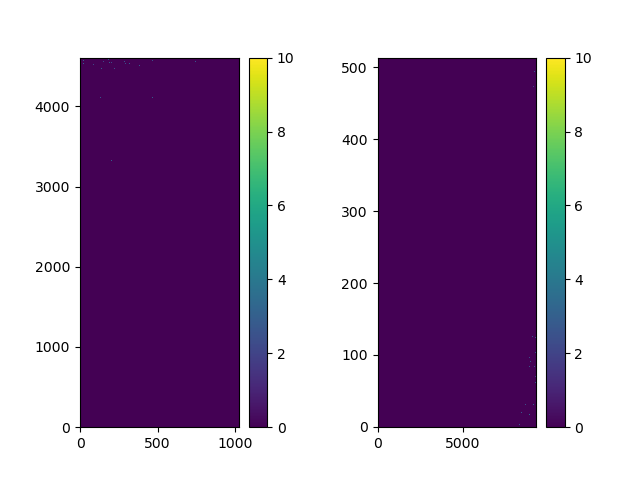

In [4]:
# First we load the first images of a file to check if everything is fine with the pedestal & gain files (check highgain True or False)
# We can see also how the ROIs look like (will be useful later)
clock = Clock()

fileName = "run_000441.JF02T09V02.h5"
#fileName = "CytC_Fe3_timescan_5uJ_288nm_7122eV_003_step0015.JF02T09V01.h5"

print(DIR + fileName)

nframes = 10
#nframes = images.shape[0]
total = 0

with ju.File(DIR + fileName, gain_file=gain_file, pedestal_file=pede_file) as juf:
    pulse_ids = juf["pulse_id"][:]
    images = juf[:]

    # compatibility assignments
    G = juf.handler.gain[:]
    P = juf.handler.pedestal[:]
    mask = juf.handler.pixel_mask[:]

    for i in range(nframes):
        image = juf[i, :]
        image_thr = image.copy()
        image_thr[image < 2] = 0
        total += image_thr
    #total /= nframes

print (total_corr.shape)
print ("It took", clock.tick(), "seconds to process this file")

#roi = [[225, 325], [6950, 7075]]
#roi = [[225, 325], [7900, 8450]]
#roi = [[0, total_corr.shape[0]], [0, total_corr.shape[1]]]

plt.figure()
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.imshow(total, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.subplot(122)
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


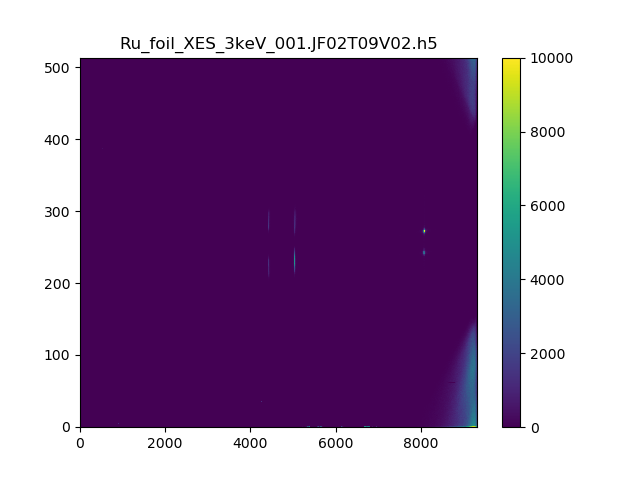

In [24]:
plt.figure()
plt.imshow(total_corr, origin="lower", aspect='auto', vmin=0, vmax=10000)
plt.title(fileName)
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


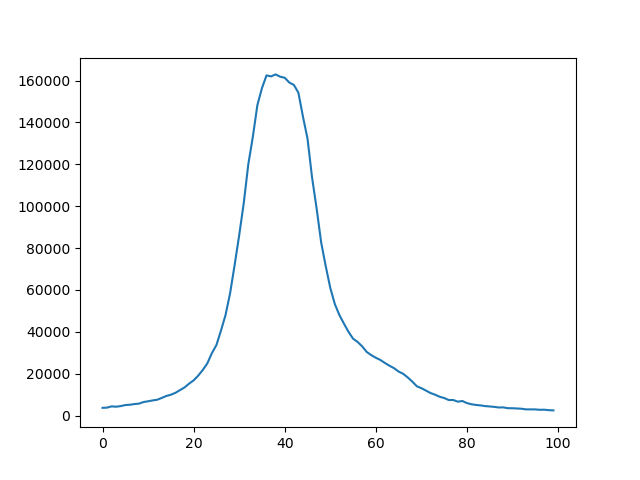

In [22]:
projection = total_corr[:,5000:5100].sum(axis = 0)

plt.figure()
plt.plot(projection)
plt.show()

In [18]:
7900 + 175

8075

# New script in the next cell (single file)

In [5]:
files = ["run_000441"]
#files = ["run_000042"]

roi1 = (4900, 5200, 150, 350)
roi2 = (6900, 7100, 200, 300)
threshold_low = 2
threshold_high = 10

######################################################################################
start_time = time.time()
spectrum_ON_roi1 = 0
spectrum_OFF_roi1 = 0
spectrum_ON_roi2 = 0
spectrum_OFF_roi2 = 0
energy_eV = 0
        
for f in files:
    JF_single_file = DIR + f + ".JF02T09V02.h5"
    BS_single_file = DIR + f + ".BSREAD.h5"
    print("Processing file %s" % (JF_single_file))
    
#    photon_range = (6, 7)

#    nshots = 10  # put this to None for ALL images
    nshots = None

    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_data_on_off(JF_single_file, roi1, roi2, 50, 25, G=G, P=P, pixel_mask=mask, highgain=False, nshots=nshots)
    
#    Izero_pump, Izero_unpump, energy_eV, pulseIDs = \
#    load_FEL_pp_pulseID(BS_single_file, channel_energy, 50, 25, 50)  
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
#   images_ON_roi1 = convert_to_photon_num_range(images_ON_roi1)

    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2[images_ON_roi2 > threshold_high] = 0
#   images_ON_roi2 = convert_to_photon_num_range(images_ON_roi2)

    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
#   images_OFF_roi1 = convert_to_photon_num_range(images_OFF_roi1)

    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2[images_OFF_roi2 > threshold_high] = 0
#   images_OFF_roi2 = convert_to_photon_num_range(images_OFF_roi2)

    spectrum_ON_roi1  = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2  = images_ON_roi2.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2.sum(axis = 1).sum(axis = 0)
    
print ("Job done! It took", round((time.time() - start_time), 2), "seconds to process", len(files), "file" if len(files) == 1 else "files")

Processing file /sf/alvra/data/p17983/raw/XES_2836.5eV_10ps/run_000441.JF02T09V02.h5
Will apply module map: [-1 -1 -1  0  1  2  3  4  5]
Job done! It took 1208.61 seconds to process 1 file


<IPython.core.display.Javascript object>


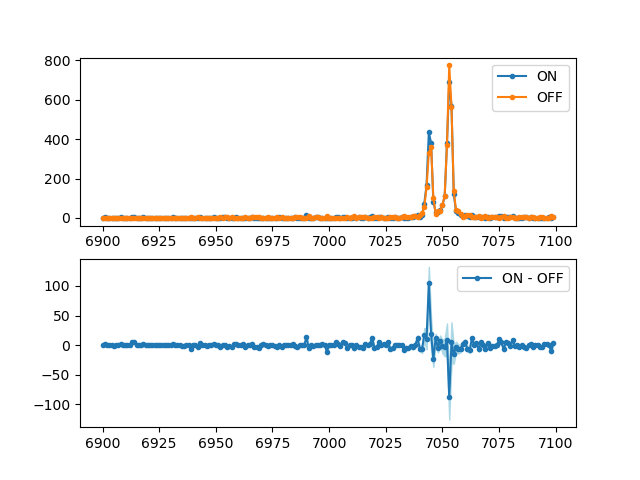

In [6]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(roi2[0], roi2[1])

spectra_on_rebin2  = bin_sum(spectra_on,  bin_)
spectra_off_rebin2 = bin_sum(spectra_off, bin_)
x_axis_rebin2 = bin_mean(x_axis, bin_)

spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
#plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


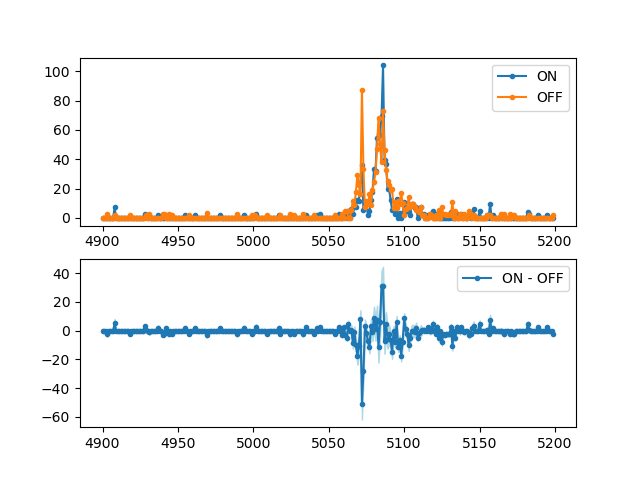

In [7]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi1.copy()
spectra_off = spectrum_OFF_roi1.copy()

x_axis = np.arange(roi1[0], roi1[1])

spectra_on_rebin1  = bin_sum(spectra_on,  bin_)
spectra_off_rebin1 = bin_sum(spectra_off, bin_)
x_axis_rebin1 = bin_mean(x_axis, bin_)

spectra_on_err1  = np.sqrt(spectra_on_rebin1)
spectra_off_err1 = np.sqrt(spectra_off_rebin1)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin1, spectra_on_rebin1, label="ON", marker='.')
plt.plot(x_axis_rebin1, spectra_off_rebin1, label="OFF", marker='.')
plt.legend(loc="best")
#plt.title(jf_file)

low_err= (spectra_on_rebin1 - spectra_off_rebin1)-np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
high_err= (spectra_on_rebin1 - spectra_off_rebin1)+np.sqrt(spectra_on_err1**2+spectra_off_err1**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin1,spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin1, low_err, high_err, color='lightblue')
plt.show()

<IPython.core.display.Javascript object>


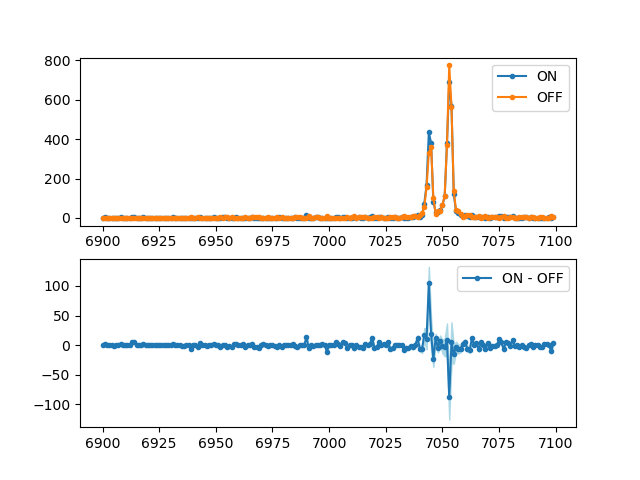

In [8]:
bin_ = 1   # change the bin size if wanted, 1 is every pixel

spectra_on = spectrum_ON_roi2.copy()
spectra_off = spectrum_OFF_roi2.copy()

x_axis = np.arange(roi2[0], roi2[1])

spectra_on_rebin2  = bin_sum(spectra_on,  bin_)
spectra_off_rebin2 = bin_sum(spectra_off, bin_)
x_axis_rebin2 = bin_mean(x_axis, bin_)

spectra_on_err2  = np.sqrt(spectra_on_rebin2)
spectra_off_err2 = np.sqrt(spectra_off_rebin2)

#spectrumAllOutFoc=spectra_on_rebin1 + spectra_off_rebin1
plt.figure()
plt.subplot(211)
plt.plot(x_axis_rebin2, spectra_on_rebin2, label="ON", marker='.')
plt.plot(x_axis_rebin2, spectra_off_rebin2, label="OFF", marker='.')
plt.legend(loc="best")
#plt.title(jf_file)

low_err= (spectra_on_rebin2 - spectra_off_rebin2)-np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
high_err= (spectra_on_rebin2 - spectra_off_rebin2)+np.sqrt(spectra_on_err2**2+spectra_off_err2**2)
#x_axis_rebin1,
plt.subplot(212)
plt.plot(x_axis_rebin2,spectra_on_rebin2 - spectra_off_rebin2, label="ON - OFF",marker='.')
#plt.plot(spectra_on_rebin1 - spectra_off_rebin1, label="ON - OFF",marker='.')

plt.legend(loc="best")
plt.fill_between(x_axis_rebin2, low_err, high_err, color='lightblue')
plt.show()

# New script in the next cell (scans) 

In [76]:
scan_name = "Ru_foil_monoscan_001"          # you need to change only this name

roi1 = (4900, 5200, 150, 350)
roi2 = (6900, 7200, 200, 300)
threshold_low = 2
threshold_high = 10

######################################################################################

fname_scan = DIR_json + scan_name + "_scan_info.json"
scan_data = load_scan_data(fname_scan)

Energy_eV = []
Delay_mm = []
XAS_roi1 = []
Error_XAS_roi1 = []
XAS_roi2 = []
Error_XAS_roi2 = []
RIXS_transient_roi1 = []
RIXS_transient_roi2 = []
Error_transient_roi1 = []
Error_transient_roi2 = []
RIXS_unpumped_roi1 = []
RIXS_unpumped_roi2 = []
Error_unpumped_roi1 = []
Error_unpumped_roi2 = []
RIXS_pumped_roi1 = []
RIXS_pumped_roi2 = []
Error_pumped_roi1 = []
Error_pumped_roi2 = []

clock = Clock()
num_scan_files = len(scan_data)
print("\nProcessing", num_scan_files, "files total")

for i, (bs, fn) in enumerate(scan_data):
#     fn2 = fn.split(".JF06T32V01.h5")[0] + ".JF02T09V02.h5"
    fn = fn.replace(".JF06T32V01.h5", ".JF02T09V02.h5")
    print("\nFile", i+1, "of", num_scan_files, ": Processing:", fn2.split("/")[-1])
    
    spectrum_ON_roi1 = 0
    spectrum_OFF_roi1 = 0
    spectrum_ON_roi2 = 0
    spectrum_OFF_roi2 = 0
    
    #nshots = 10  # put this to None for ALL images
    nshots = None
    
    images_ON_roi1, images_ON_roi2, pids_ON, images_OFF_roi1, images_OFF_roi2, pids_OFF = \
    load_crop_JF_data_on_off(fn2, roi1, roi2, 50, 25, G=G, P=P, pixel_mask=mask, highgain=False, nshots=nshots)
    
    energy, pids = load_single_channel_pulseID(bs, channel_energy, 50)
    energy = [x for x in energy if (x > 0)]
    Energy_eV.append(np.mean(energy))
    
    images_ON_roi1_thr = images_ON_roi1.copy()
    images_ON_roi1_thr[images_ON_roi1 < threshold_low] = 0
    images_ON_roi1_thr[images_ON_roi1 > threshold_high] = 0
    
    images_OFF_roi1_thr = images_OFF_roi1.copy()
    images_OFF_roi1_thr[images_OFF_roi1 < threshold_low] = 0
    images_OFF_roi1_thr[images_OFF_roi1 > threshold_high] = 0
    
    images_ON_roi2_thr = images_ON_roi2.copy()
    images_ON_roi2_thr[images_ON_roi2 < threshold_low] = 0
    images_ON_roi2_thr[images_ON_roi2 > threshold_high] = 0
    
    images_OFF_roi2_thr = images_OFF_roi2.copy()
    images_OFF_roi2_thr[images_OFF_roi2 < threshold_low] = 0
    images_OFF_roi2_thr[images_OFF_roi2 > threshold_high] = 0
    
    spectrum_ON_roi1 = images_ON_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi1 = images_OFF_roi1_thr.sum(axis = 1).sum(axis = 0)
    spectrum_ON_roi2 = images_ON_roi2_thr.sum(axis = 1).sum(axis = 0)
    spectrum_OFF_roi2 = images_OFF_roi2_thr.sum(axis = 1).sum(axis = 0)
    
    XAS_roi1.append(np.abs(spectrum_OFF_roi1.sum()))
    RIXS_unpumped_roi1.append(spectrum_OFF_roi1)
    Error_unpumped_roi1.append(np.sqrt(spectrum_OFF_roi1))
    RIXS_pumped_roi1.append(spectrum_ON_roi1)
    Error_pumped_roi1.append(np.sqrt(spectrum_ON_roi1))
    RIXS_transient_roi1.append(spectrum_ON_roi1 - spectrum_OFF_roi1)
    Error_transient_roi1.append(np.sqrt((np.sqrt(spectrum_ON_roi1))**2 + (np.sqrt(spectrum_OFF_roi1))**2))
    
    print ("It took", clock.tick(), "seconds to process this file")

Energy_eV = np.array(Energy_eV)
XAS_roi1 = np.array(XAS_roi1)
RIXS_unpumped_roi1 = np.array(RIXS_unpumped_roi1)
Error_unpumped_roi1 = np.array(Error_unpumped_roi1)
RIXS_pumped_roi1 = np.array(RIXS_pumped_roi1)
Error_pumped_roi1 = np.array(Error_pumped_roi1)
RIXS_transient_roi1 = np.array(RIXS_transient_roi1)
Error_transient_roi1 = np.array(Error_transient_roi1)

print ("\nJob done! It took", clock.tock(), "seconds to process", num_scan_files, "file(s)")




Processing 21 files total

File 1 of 21 : Processing: Ru_foil_monoscan_001_step0000.JF02T09V02.h5
All modules are active


/sf/alvra/anaconda/dev/lib/python3.6/site-packages/jungfrau_utils/corrections.py:202: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  res = np.stack(partial_func_to_use(i) for i in image)


It took 0.41 seconds to process this file

File 2 of 21 : Processing: Ru_foil_monoscan_001_step0001.JF02T09V02.h5
All modules are active
It took 0.35 seconds to process this file

File 3 of 21 : Processing: Ru_foil_monoscan_001_step0002.JF02T09V02.h5
All modules are active
It took 0.31 seconds to process this file

File 4 of 21 : Processing: Ru_foil_monoscan_001_step0003.JF02T09V02.h5
All modules are active
It took 0.32 seconds to process this file

File 5 of 21 : Processing: Ru_foil_monoscan_001_step0004.JF02T09V02.h5
All modules are active
It took 0.29 seconds to process this file

File 6 of 21 : Processing: Ru_foil_monoscan_001_step0005.JF02T09V02.h5
All modules are active
It took 0.37 seconds to process this file

File 7 of 21 : Processing: Ru_foil_monoscan_001_step0006.JF02T09V02.h5
All modules are active
It took 0.29 seconds to process this file

File 8 of 21 : Processing: Ru_foil_monoscan_001_step0007.JF02T09V02.h5
All modules are active
It took 0.36 seconds to process this file

<IPython.core.display.Javascript object>


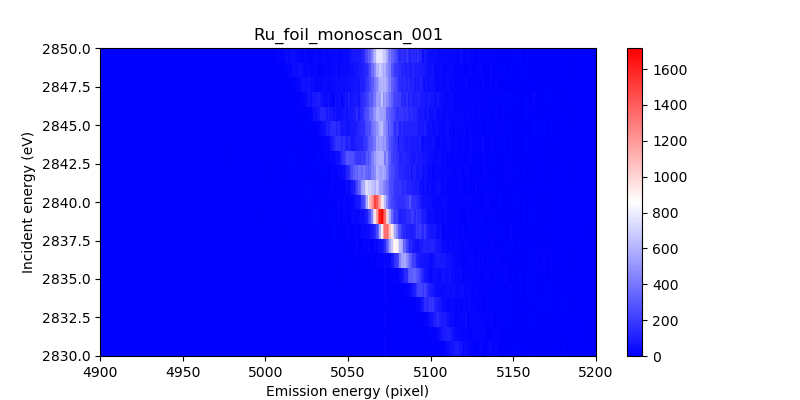

In [57]:
RIXS_total = RIXS_unpumped_roi1 + RIXS_pumped_roi1

plt.figure(figsize=(8,4))
plt.imshow(RIXS_total, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.xlabel("Emission energy (pixel)")
plt.ylabel("Incident energy (eV)")

plt.title(scan_name)
plt.colorbar()
plt.show()


<IPython.core.display.Javascript object>


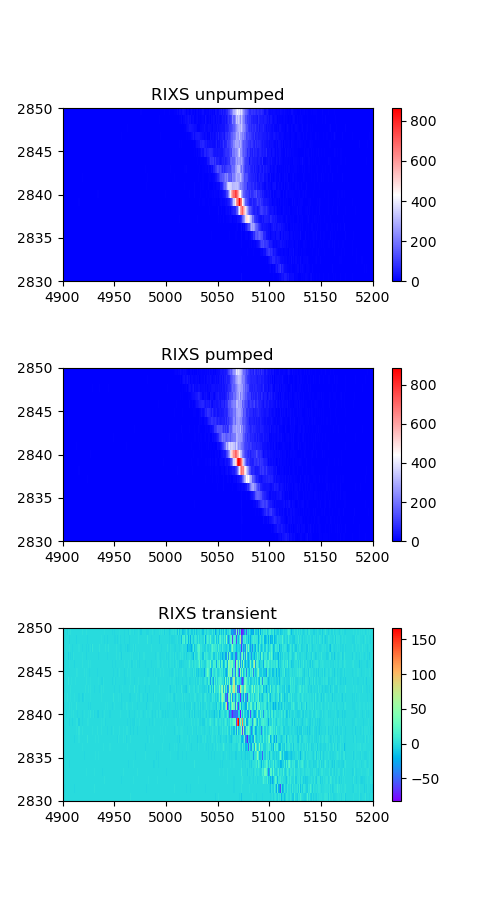

In [51]:
plt.figure(figsize=(5,9))
plt.subplots_adjust(hspace=0.5)

plt.subplot(311)
plt.imshow(RIXS_unpumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])
plt.title("RIXS unpumped")
plt.colorbar()
plt.show()

plt.subplot(312)
plt.imshow(RIXS_pumped_roi1, aspect = 'auto', cmap = "bwr", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-250, vmax=250)
plt.title("RIXS pumped")
plt.colorbar()
plt.show()

plt.subplot(313)
plt.imshow(RIXS_transient_roi1, aspect = 'auto', cmap = "rainbow", origin ="lower", extent=[roi1[0], roi1[1], Energy_eV[0], Energy_eV[-1]])#, vmin=-0.03, vmax=0.03)
plt.title("RIXS transient")
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


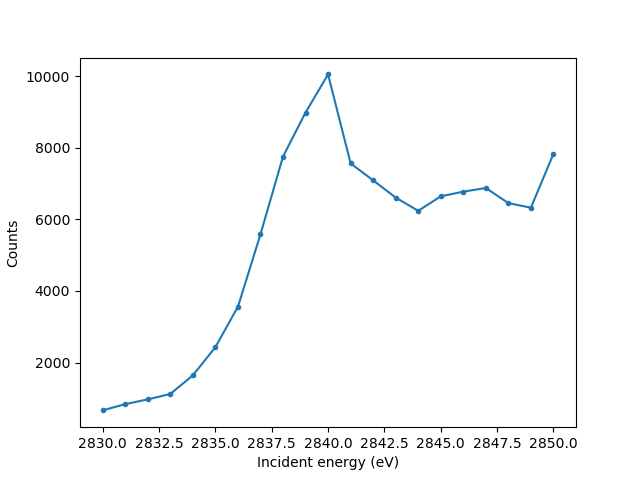

<function matplotlib.pyplot.show(*args, **kw)>

In [59]:
plt.figure()
plt.plot(Energy_eV,XAS_roi1, label="", marker='.')
plt.xlabel("Incident energy (eV)")
plt.ylabel("Counts")
plt.show